In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno
from scipy.optimize import curve_fit
from google.colab import files


In [ ]:
uploaded = files.upload()

Saving AB_NYC_2019.csv to AB_NYC_2019 (1).csv


In [ ]:
data = pd.read_csv('AB_NYC_2019.csv')

In [ ]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
#Preprocessing 'last_review' column: extracting year, and sorting descendingly.

data['last_review'] = pd.to_datetime(data['last_review'], format='%Y-%m-%d')
data['last_review'] = data['last_review'].dt.year

#Renaming the columns in order to be more adjusted to the subject

data['room_type'] = data['room_type'].replace('Entire home/apt', 'Entire home')
data = data.rename(columns={"neighbourhood_group": "Place", "neighbourhood": "Hood", "latitude": "Lat",
                        "longitude": "Lot", "room_type": "Type", "price": "Price",'last_review':'Year'})

#Cleaning the data: subtracting rows with missing values
data = data.dropna()
data = data.sort_values(by=['Year'], ascending=False)
data = data.reset_index(drop=True)
data['Year']


,Year
0,2019.0
1,2019.0
2,2019.0
3,2019.0
4,2019.0
...,...
38816,2011.0
38817,2011.0
38818,2011.0
38819,2011.0


Year
2011.0        7
2012.0       25
2013.0       48
2014.0      199
2015.0     1388
2016.0     2703
2017.0     3203
2018.0     6047
2019.0    25201
Name: count, dtype: int64


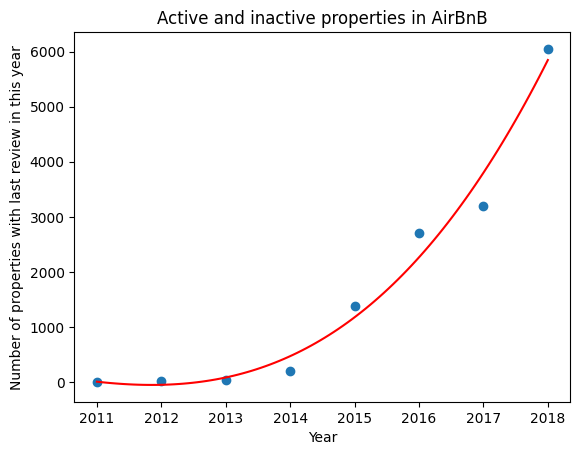

In [ ]:
#Machine Learning analysis
#
#The first undertaken task is to reconstruct from the very limited, aggregated data from 2023 - the number of active and inactive properties
# from each subsequent year from 2011-2019 timeframe. As the basic set is limited only to 16 columns, with no direct data on the subject, we have to apply
# deeper feature engineering to derive needed information. This can be deduced using "last_review" - returning a time of when the property was review by the guest
# last time. The assumption applied here, straightforwardly obvious, is that when the property is not reviewed for a year, that means it no longer in use.
# Therefore, "last_review" limited only to the year, directly conveys the information of the last denoted year of activity (excluding 2019). Having this information drawn,
# we can see the rising trend of inactive properties in the set. However, 2019 towers above the preceding values, beacuse it stands for both active
# and inactive (of unknown proportion) properties as the last recorded year.
# Briefly, the task may be divided into 3 steps:
#     1. Predicting the number of inactive properties in 2019 basing on the trend from 2011-2018
#     2. Calculating the 'inactives to all properties' ratio in 2019
#     3. Propagating back the obtained ratio from pt.2 for years 2011-2018 in order to get the number of total listed properties
# Note: step 3 requires another assumption: that the inactives to all properties' ratio in constant over time and applyable to years 2011-2018. For several following
# reasons we find this assumption plausible for the sake of this analysis: a) we took advantage of the given timeframe: relative stable economy,
# no global war or turmoils, real estate market recovered after 2008 crisis, yet not affected by upcoming COVID-19 effect; b) the analysis is based on a very limited
# scope, and our goal is to make use of the data as it is -- with the uncertainty of the obtained outcomes properly pointed out;  presumably the management of AirBnB
# after fiding the results promising, could provide a deeper dataset that will not require applying these assumptions.


#We calulate a list of years appearing in the dataset associated with the number of appearances
year_count = data['Year'].value_counts().sort_index()

# STEP 1
#     Predicting the number of inactive properties in 2019 basing on the trend from 2011-2018
#

# In order to create and adjust optimal curve following given data points. Fortunately, after visual examination
# most likely it is a low-degree polynomial. We decided to use a 3rd degree polynomial as a candidate function and use least square method to callibrate its parameters.
# Our model function: 3rd degree polynomial f(x)=ax^3+bx^2+cx+d

def model_f(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

x_data = [0,1,2,3,4,5,6,7]
year_count_full = year_count.copy(deep=True)
year_count.drop(year_count .tail(1).index,inplace=True)
y_data = year_count
print(year_count_full)

#Finding most optimal curve from the given model. We use given 'curve_fit' function from SciPy library.
#Model_f - is our candidate function, x_data and y_data are datasets to be corelated, p0 is the boundary condition,
# which obviously tells that in year 0 the number of inactives was 0.
popt, pcov = curve_fit(model_f, x_data, y_data.to_numpy(), p0=[0,0,0,0])

a_opt, b_opt, c_opt, d_opt = popt
x_model = np.linspace(min(x_data), max(x_data), 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt, d_opt)

#After finding the most fitting model, we draw the curve and the historical points to double-check whether it visually follows them.

plt.scatter(x_data, y_data)
labels = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


plt.plot(x_model, y_model, color='r')
plt.xlabel("Year")
plt.ylabel("Number of properties with last review in this year")
plt.title("Active and inactive properties in AirBnB")
plt.xticks(x_data, labels)

plt.show()



In [ ]:
#We print some details on obtained results

#Function equation
print("Function equation: \n f(year) = ",round(a_opt,2),"*x^3+",round(b_opt,2),"*x^2+",round(c_opt,2),"*x+",round(d_opt,2))
r_2019 = a_opt*8**3+b_opt*8**2+c_opt*8+d_opt

# STEP 2
#     2. Calculating the 'inactives to all properties' ratio in 2019
#

print("\nPrediction for 2019: ", round(r_2019,2))
actToInactRatio = r_2019/year_count_full.values[-1]
print("\nInactive to active properties ratio: ",round(actToInactRatio,2))

print("\nCovariance matrix or errors:\n")
print(pcov)

#Calculating R squared indicator for the curve. Once this parameter is closer to 1, it means that the model represents the data used to constuct is.

residuals = y_data- model_f(np.array(x_data), *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)
print("\nR^2=",r_squared)

#Obtained R^2 result is very close to 1, therefore we find our candidate function useful.


Function equation: 
 f(year) =  10.7 *x^3+ 62.74 *x^2+ -129.97 *x+ 10.71

Prediction for 2019:  8465.5

Inactive to active properties ratio:  0.34

Covariance matrix or errors:

[[    300.53575774   -3155.62498626    8264.72923972   -3155.61636831]
 [  -3155.62498626   34196.6678422   -94217.9191353    40572.24397097]
 [   8264.72923972  -94217.9191353   283598.32736972 -153723.91843695]
 [  -3155.61636831   40572.24397097 -153723.91843695  159584.56180573]]

R^2= 0.9783040040715334


[0, 1, 2, 3, 4, 5, 6, 7, 8]


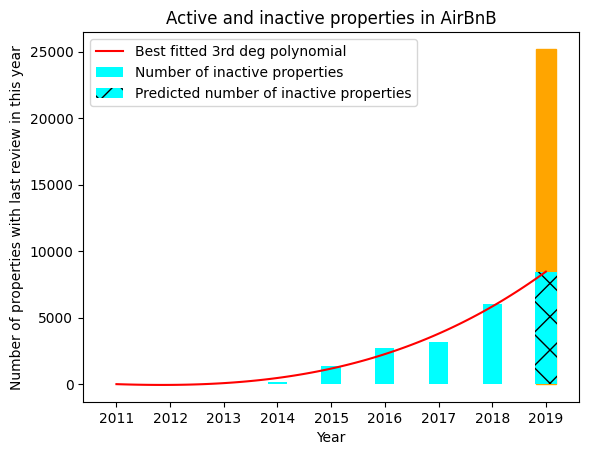

In [ ]:
# Drawing the results of predicted value of inactive properties in 2019

x_data.insert(9,8)
labels.insert(9,'2019')
x_model = np.linspace(min(x_data), max(x_data), 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt, d_opt)

plt.plot(x_model, y_model, color='r')
# naming of x-axis and y-axis
plt.xlabel("Year")
plt.ylabel("Number of properties with last review in this year")
# naming the title of the plot
plt.title("Active and inactive properties in AirBnB")
plt.xticks(x_data, labels)
barlist=plt.bar(x_data, year_count_full.to_numpy(), color ='cyan', width = 0.36)
barlist[-1].set_color('orange')
barlist2=plt.bar(x_data,[0,0,0,0,0,0,0,0,r_2019],color='cyan',width=0.4,hatch="x")
plt.legend(["Best fitted 3rd deg polynomial ", "Number of inactive properties", "Predicted number of inactive properties","Number of active properties"], loc="upper left", markerscale=0.2)

In [ ]:
# STEP 3
#     3. Propagating back the obtained ratio from pt.2 for years 2011-2018 in order to get the number of total listed properties
#

print("Having calculated the inactive/active ratio, we apply the result to each value from 2011 - 2018.")
print("The number of properties in total (actives + inactives):")
allProperties = []

for x in range(8):
  allProperties.append(round(year_count_full.values[x]/actToInactRatio,0))
allProperties.append(0)
print(allProperties)

Having calculated the inactive/active ratio, we apply the result to each value from 2011 - 2018.
The number of properties in total (actives + inactives):
[21.0, 74.0, 143.0, 592.0, 4132.0, 8047.0, 9535.0, 18001.0, 0]


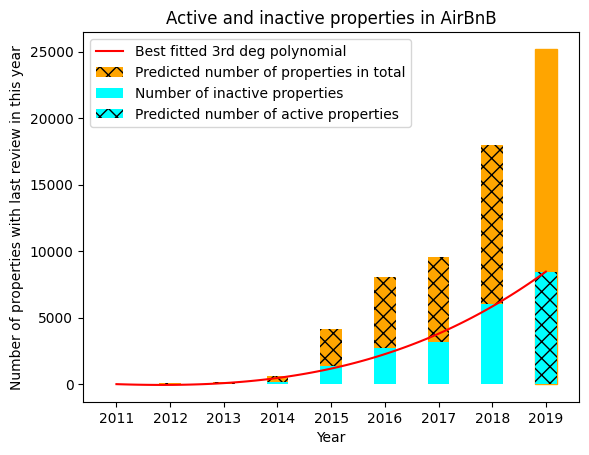

In [ ]:
plt.plot(x_model, y_model, color='r')
# naming of x-axis and y-axis
plt.xlabel("Year")
plt.ylabel("Number of properties with last review in this year")
# naming the title of the plot
plt.title("Active and inactive properties in AirBnB")
plt.xticks(x_data, labels)

barlist3=plt.bar(x_data,allProperties,color='orange',width=0.4, hatch="xx")
barlist3[-1].hatch=""
barlist=plt.bar(x_data, year_count_full.to_numpy(), color ='cyan', width = 0.4)
barlist[-1].set_color('orange')
barlist2=plt.bar(x_data,[0,0,0,0,0,0,0,0,r_2019],color='cyan',width=0.4,hatch="xx")

plt.legend(["Best fitted 3rd deg polynomial ",
            "Predicted number of properties in total",
            "Number of inactive properties",
            "Predicted number of active properties",
            "next"], loc="upper left", markerscale=0.2)